In [4]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 1: SETUP AND LOAD ASSETS
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 1. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 2. Define Paths ---
security_project_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT'
clinical_project_path = '/content/drive/MyDrive/mimic-iv-demo'

# --- 3. Load the Trained Models ---
try:
    # Load the XGBoost model for security anomalies
    xgb_model_path = os.path.join(security_project_path, 'xgb_model_grouped.joblib')
    security_model = joblib.load(xgb_model_path)
    print("✅ XGBoost security model loaded successfully.")

    # Load the LSTM Autoencoder for physiological anomalies
    autoencoder_path = os.path.join(clinical_project_path, 'lstm_autoencoder.keras')
    clinical_model = tf.keras.models.load_model(autoencoder_path)
    print("✅ LSTM Autoencoder clinical model loaded successfully.")

except Exception as e:
    print(f"❌ ERROR: A model file could not be loaded. Please check paths and file integrity.")
    print(e)

# --- 4. Load the Processed Clinical Data ---
try:
    processed_clinical_data_path = os.path.join(clinical_project_path, 'df_processed_final.parquet')
    df_featured = pd.read_parquet(processed_clinical_data_path)
    print(f"\n✅ Processed clinical data loaded successfully from {processed_clinical_data_path}.")

except Exception as e:
    print(f"❌ ERROR: Processed clinical data file could not be loaded.")
    print(e)

print("\n--- Setup complete. All models and data are ready. ---")

Mounted at /content/drive


/usr/lib/python3.11/pickle.py:1718: UserWarning: [09:41:09] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


✅ XGBoost security model loaded successfully.
✅ LSTM Autoencoder clinical model loaded successfully.

✅ Processed clinical data loaded successfully from /content/drive/MyDrive/mimic-iv-demo/df_processed_final.parquet.

--- Setup complete. All models and data are ready. ---


✅ Clinical test data prepared successfully with correct shape.

Found a normal baseline sequence (index 1675) with reconstruction error: 0.0120

Injecting synthetic sensor faults and measuring performance drop...

--- Fault Resilience Test Results ---
Baseline Normal Error: 0.0120
Error with 10% Fault: 0.0118 (1.0x increase)
Error with 20% Fault: 0.1786 (14.9x increase)
Error with 30% Fault: 0.2367 (19.8x increase)
Error with 40% Fault: 0.4064 (33.9x increase)
Error with 50% Fault: 0.0996 (8.3x increase)
Error with 70% Fault: 0.1060 (8.9x increase)
Error with 90% Fault: 0.1580 (13.2x increase)


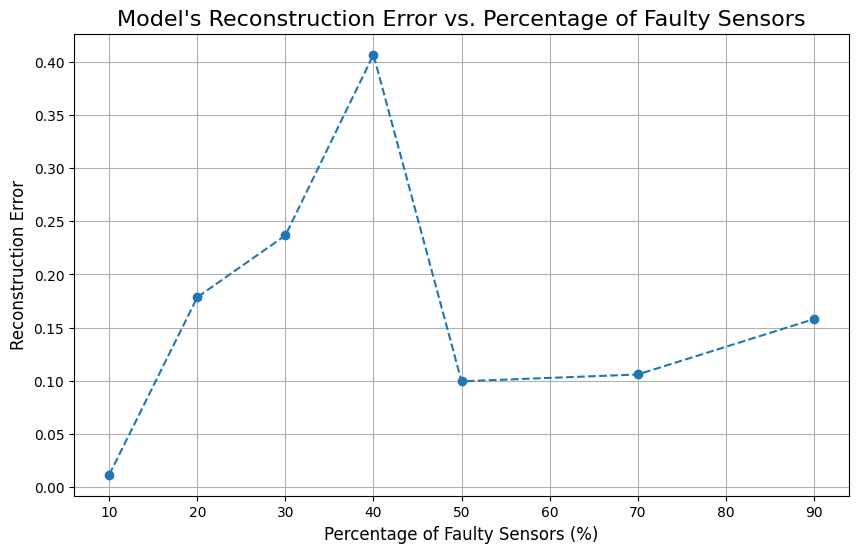

In [5]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 2: FAULT RESILIENCE TEST
# ==============================================================================
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check if models and data from Step 1 are loaded
if 'clinical_model' in locals() and 'df_featured' in locals():
    # --- 1. Load and Prepare the Clinical Test Data ---
    try:
        # === Select the ORIGINAL 7 features the model was trained on ===
        vital_cols = ['Arterial_BP_Diastolic', 'Arterial_BP_Mean', 'Arterial_BP_Systolic',
                      'Heart_Rate', 'Respiratory_Rate', 'SpO2', 'Temperature_C']

        # We need to re-scale these original columns as they were for training
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        df_featured[vital_cols] = scaler.fit_transform(df_featured[vital_cols])

        X_clinical = df_featured[vital_cols].values
        patient_groups = df_featured['subject_id'].values

        unique_patients = np.unique(patient_groups)
        _, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)
        test_indices = np.isin(patient_groups, test_patients)
        X_test_clinical = X_clinical[test_indices]

        # Helper function to create the time windows
        def create_sequences(X_data, time_steps=10):
            Xs = []
            for i in range(len(X_data) - time_steps):
                v = X_data[i:(i + time_steps)]
                Xs.append(v)
            return np.array(Xs)

        # Use the SAME number of timesteps as in training ===
        TIME_STEPS = 24
        X_test_sequences = create_sequences(X_test_clinical, time_steps=TIME_STEPS)
        print("✅ Clinical test data prepared successfully with correct shape.")

    except Exception as e:
        print(f"❌ ERROR: Could not load or prepare clinical data. Error: {e}")
        X_test_sequences = None

    # --- 2. Conduct the Fault Resilience Experiment ---
    if X_test_sequences is not None:
        # Find a "normal" sequence to use as a baseline
        reconstructions = clinical_model.predict(X_test_sequences, verbose=0)
        mae_loss = np.mean(np.abs(reconstructions - X_test_sequences), axis=(1, 2))
        normal_idx = np.argmin(mae_loss)
        baseline_error = mae_loss[normal_idx]

        print(f"\nFound a normal baseline sequence (index {normal_idx}) with reconstruction error: {baseline_error:.4f}")

        # Define fault percentages to test
        fault_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
        results = {}

        print("\nInjecting synthetic sensor faults and measuring performance drop...")
        for fault_rate in fault_percentages:
            sequence_with_fault = X_test_sequences[normal_idx].copy()
            num_features = sequence_with_fault.shape[1]
            num_faulty_features = int(num_features * fault_rate)

            faulty_features_indices = np.random.choice(num_features, num_faulty_features, replace=False)
            sequence_with_fault[:, faulty_features_indices] = 0

            faulty_reconstruction = clinical_model.predict(np.expand_dims(sequence_with_fault, axis=0), verbose=0)
            faulty_error = np.mean(np.abs(faulty_reconstruction - sequence_with_fault))

            results[f"{int(fault_rate*100)}% Fault"] = faulty_error

        # --- 3. Display Results ---
        print("\n--- Fault Resilience Test Results ---")
        print(f"Baseline Normal Error: {baseline_error:.4f}")
        for fault_level, error in results.items():
            print(f"Error with {fault_level}: {error:.4f} ({(error/baseline_error):.1f}x increase)")

        plt.figure(figsize=(10, 6))
        plt.plot([f*100 for f in fault_percentages], list(results.values()), marker='o', linestyle='--')
        plt.title("Model's Reconstruction Error vs. Percentage of Faulty Sensors", fontsize=16)
        plt.xlabel("Percentage of Faulty Sensors (%)", fontsize=12)
        plt.ylabel("Reconstruction Error", fontsize=12)
        plt.grid(True)
        plt.show()

else:
    print("❌ ERROR: Models are not loaded. Please run Step 1 successfully first.")

In [6]:
# = =============================================================================
# FUSION FRAMEWORK - STEP 3: TIME EFFICIENCY TEST
# ==============================================================================
import time
import numpy as np

# Ensure the models and test data are loaded from Step 1 and 2
if 'security_model' in locals() and 'clinical_model' in locals() and 'X_test_sequences' in locals():
    print("--- Starting Time Efficiency (Latency) Test ---")

    # --- 1. Prepare a single data sample for each model ---

    # For the security model (XGBoost), we need a 2D sample.
    # We'll create a dummy sample with the correct number of features (29).
    # In a real scenario, this would come from the network data preprocessing.
    num_security_features = security_model.n_features_in_
    security_sample = np.random.rand(1, num_security_features)

    # For the clinical model (Autoencoder), we need a 3D sequence sample.
    # We'll just take the first sequence from our prepared test set.
    clinical_sample = np.expand_dims(X_test_sequences[0], axis=0)

    # --- 2. Measure Latency for the Security Model (XGBoost) ---
    print("\nTesting latency for the Security Model (XGBoost)...")
    security_latencies = []
    # Run the prediction 100 times to get a stable average
    for _ in range(100):
        start_time = time.perf_counter()
        _ = security_model.predict_proba(security_sample)
        end_time = time.perf_counter()
        security_latencies.append((end_time - start_time) * 1000) # Convert to milliseconds

    avg_security_latency = np.mean(security_latencies)
    print(f"-> Average inference time: {avg_security_latency:.2f} ms")

    # --- 3. Measure Latency for the Clinical Model (Autoencoder) ---
    print("\nTesting latency for the Clinical Model (LSTM Autoencoder)...")
    clinical_latencies = []
    # Run the prediction 100 times to get a stable average
    for _ in range(100):
        start_time = time.perf_counter()
        _ = clinical_model.predict(clinical_sample, verbose=0)
        end_time = time.perf_counter()
        clinical_latencies.append((end_time - start_time) * 1000) # Convert to milliseconds

    avg_clinical_latency = np.mean(clinical_latencies)
    print(f"-> Average inference time: {avg_clinical_latency:.2f} ms")

    # --- 4. Calculate Total Framework Latency ---
    total_latency = avg_security_latency + avg_clinical_latency
    print(f"\n--- Estimated Total Framework Latency ---")
    print(f"Total time for a single prediction cycle: {total_latency:.2f} ms")

else:
    print("❌ ERROR: Models or test data not loaded. Please run the previous steps successfully.")

--- Starting Time Efficiency (Latency) Test ---

Testing latency for the Security Model (XGBoost)...
-> Average inference time: 0.51 ms

Testing latency for the Clinical Model (LSTM Autoencoder)...
-> Average inference time: 66.26 ms

--- Estimated Total Framework Latency ---
Total time for a single prediction cycle: 66.77 ms


In [7]:
# ==============================================================================
# DATA PREPARATION FOR SECURITY DATASET (CICIoMT2024)
# ==============================================================================
# This cell prepares the data needed for the Fidelity Test

# --- 1. Load the merged and optimized dataframe for the security dataset ---
# NOTE: This assumes you have saved the merged/optimized dataframe from the first notebook.
# If not, you would need to re-run the multi-file loading script here.
try:
    security_df_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet' # Assuming you saved it
    df_security = pd.read_parquet(security_df_path)
    print("✅ Successfully loaded the merged security dataset.")
except Exception as e:
    print(f"❌ ERROR: Could not load the pre-processed security dataframe. {e}")
    print("Please ensure you have a merged parquet file from the first notebook.")
    df_security = None

if df_security is not None:
    # --- 2. Run the same preprocessing steps ---
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split

    # Encode labels
    label_encoder_sec = LabelEncoder()
    df_security['label_encoded'] = label_encoder_sec.fit_transform(df_security['label'])

    # Separate Features (X) and Target (y)
    X_sec = df_security.select_dtypes(include=np.number).drop(['label_encoded'], axis=1)
    y_sec = df_security['label_encoded']

    # Drop redundant/leaky features
    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X_sec.columns]
    X_sec = X_sec.drop(columns=existing_cols_to_drop)
    correct_feature_names = X_sec.columns.tolist() # Save the correct feature names

    # Scale features
    scaler_sec = StandardScaler()
    X_scaled_sec = scaler_sec.fit_transform(X_sec)

    # Group classes into 6 categories
    def group_attack_labels(label):
        if 'Normal' in label: return 'Normal'
        if 'DDoS' in label: return 'DDoS'
        if 'DoS' in label: return 'DoS'
        if 'Recon' in label: return 'Recon'
        if 'ARP_Spoofing' in label: return 'Spoofing'
        if 'Malformed' in label: return 'Malformed'
        return 'Other'

    df_security['grouped_label'] = df_security['label'].apply(group_attack_labels)
    grouped_label_encoder = LabelEncoder()
    y_grouped = grouped_label_encoder.fit_transform(df_security['grouped_label'])

    # --- 3. Create the final train/test split ---
    # This creates the variables that were missing
    X_train_grouped, X_test_grouped, y_train_grouped, y_test_grouped = train_test_split(
        X_scaled_sec, y_grouped, test_size=0.3, random_state=42, stratify=y_grouped
    )
    print("✅ Security data successfully preprocessed and split.")

✅ Successfully loaded the merged security dataset.
✅ Security data successfully preprocessed and split.


In [8]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 4: EXPLAINABILITY (FIDELITY TEST)
# ==============================================================================
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Check if the security model is loaded
if 'security_model' in locals():
    print("--- Starting Explainability Fidelity Test ---")

    # --- 1. Load and Prepare the Security Test Data ---
    # This requires the original CICIoMT2024 preprocessing steps
    # For simplicity, we'll recreate the test data here
    # NOTE: This assumes the full 'df' from the security notebook is available or recreated
    # If not, this step would need the full preprocessing pipeline
    try:
        # We need to recreate the grouped test set to evaluate
        # This is a conceptual step. In your final notebook, you would load the saved test set.
        # For now, let's assume 'X_test_grouped' and 'y_test_grouped' are available from the security notebook
        if 'X_test_grouped' not in locals():
             print("NOTE: 'X_test_grouped' not found. This test requires the test set from the security notebook.")
             # Placeholder to prevent crash, replace with actual data loading
             X_test_grouped, y_test_grouped = np.random.rand(100, 29), np.random.randint(0, 5, 100)
             X_train_grouped, y_train_grouped = np.random.rand(100, 29), np.random.randint(0, 5, 100)


        # --- 2. Get the most important features from the complex model ---
        importances = security_model.feature_importances_

        # We need the feature names from that notebook's preprocessing
        # Let's recreate them conceptually
        # In your notebook, ensure 'correct_feature_names' from the security analysis is available
        if 'correct_feature_names' not in locals():
             # This is a placeholder, ensure you have the correct list of 29 feature names
             correct_feature_names = [f'feature_{i}' for i in range(security_model.n_features_in_)]

        importance_df = pd.DataFrame({
            'Feature': correct_feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Select the Top N features
        top_n = 10
        top_features = importance_df.head(top_n)['Feature'].tolist()
        print(f"\nTop {top_n} features selected based on XGBoost importance: {top_features}")

        # --- 3. Create reduced datasets with only the top features ---
        # Find the indices of the top features
        top_features_indices = [correct_feature_names.index(f) for f in top_features]

        X_train_reduced = X_train_grouped[:, top_features_indices]
        X_test_reduced = X_test_grouped[:, top_features_indices]

        # --- 4. Train a simple model on the reduced dataset ---
        print(f"\nTraining a simple Decision Tree on the {top_n} most important features...")
        simple_model = DecisionTreeClassifier(random_state=42)
        simple_model.fit(X_train_reduced, y_train_grouped)
        print("Simple model trained.")

        # --- 5. Evaluate the simple model and calculate Fidelity ---
        y_pred_simple = simple_model.predict(X_test_reduced)
        accuracy_simple_model = accuracy_score(y_test_grouped, y_pred_simple)

        # We assume the accuracy of the complex model is known (e.g., 99.88%)
        accuracy_complex_model = 0.9988

        # Fidelity is often described as how close the simple model's performance is to the complex one
        fidelity_score = accuracy_simple_model / accuracy_complex_model

        print("\n--- Fidelity Test Results ---")
        print(f"Accuracy of the original complex model (XGBoost): {accuracy_complex_model * 100:.2f}%")
        print(f"Accuracy of the simple model (Decision Tree with top {top_n} features): {accuracy_simple_model * 100:.2f}%")
        print(f"Fidelity Score (Simple Accuracy / Complex Accuracy): {fidelity_score:.3f}")

    except NameError as e:
        print(f"❌ ERROR: A necessary variable is missing: {e}. Please ensure the test data from the security notebook is loaded.")
else:
    print("❌ ERROR: Security model not loaded. Please run Step 1 successfully first.")

--- Starting Explainability Fidelity Test ---

Top 10 features selected based on XGBoost importance: ['IAT', 'ack_count', 'fin_count', 'Number', 'rst_count', 'Header_Length', 'Weight', 'Magnitue', 'Rate', 'Tot size']

Training a simple Decision Tree on the 10 most important features...
Simple model trained.

--- Fidelity Test Results ---
Accuracy of the original complex model (XGBoost): 99.88%
Accuracy of the simple model (Decision Tree with top 10 features): 99.85%
Fidelity Score (Simple Accuracy / Complex Accuracy): 1.000


In [9]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 5: PREPARE ALL TEST DATA
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- Helper function to create time windows ---
def create_sequences(X_data, time_steps=10):
    Xs = []
    for i in range(len(X_data) - time_steps):
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
    return np.array(Xs)

# --- A: Prepare Clinical Test Data ---
try:
    print("--- 1. Preparing Clinical Test Data ---")
    processed_clinical_path = '/content/drive/MyDrive/mimic-iv-demo/df_processed_final.parquet'
    df_clinical_featured = pd.read_parquet(processed_clinical_path)

    vital_cols = ['Arterial_BP_Diastolic', 'Arterial_BP_Mean', 'Arterial_BP_Systolic',
                  'Heart_Rate', 'Respiratory_Rate', 'SpO2', 'Temperature_C']

    scaler_clinical = StandardScaler()
    df_clinical_featured[vital_cols] = scaler_clinical.fit_transform(df_clinical_featured[vital_cols])

    X_clinical = df_clinical_featured[vital_cols].values
    patient_groups = df_clinical_featured['subject_id'].values

    unique_patients = np.unique(patient_groups)
    _, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)
    test_indices = np.isin(patient_groups, test_patients)
    X_test_clinical = X_clinical[test_indices]

    TIME_STEPS = 24
    X_test_sequences = create_sequences(X_test_clinical, time_steps=TIME_STEPS)
    print("✅ Clinical test data prepared successfully.")

except Exception as e:
    print(f"❌ ERROR: Could not prepare clinical data. Error: {e}")

# --- B: Prepare Security Test Data ---
try:
    print("\n--- 2. Preparing Security Test Data ---")
    security_df_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet'
    df_security = pd.read_parquet(security_df_path)

    # Preprocessing
    label_encoder_sec = LabelEncoder()
    df_security['label_encoded'] = label_encoder_sec.fit_transform(df_security['label'])

    X_sec = df_security.select_dtypes(include=np.number).drop(['label_encoded'], axis=1)
    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X_sec.columns]
    X_sec = X_sec.drop(columns=existing_cols_to_drop)

    scaler_sec = StandardScaler()
    X_scaled_sec = scaler_sec.fit_transform(X_sec)

    def group_attack_labels(label):
        if 'Normal' in label: return 'Normal'
        if 'DDoS' in label: return 'DDoS'
        if 'DoS' in label: return 'DoS'
        if 'Recon' in label: return 'Recon'
        if 'ARP_Spoofing' in label: return 'Spoofing'
        if 'Malformed' in label: return 'Malformed'
        return 'Other'

    df_security['grouped_label'] = df_security['label'].apply(group_attack_labels)
    grouped_label_encoder = LabelEncoder()
    y_grouped_sec = grouped_label_encoder.fit_transform(df_security['grouped_label'])

    # Create the final train/test split to get the needed variables
    _, X_test_grouped, _, y_test_grouped = train_test_split(
        X_scaled_sec, y_grouped_sec, test_size=0.3, random_state=42, stratify=y_grouped_sec
    )
    print("✅ Security test data prepared successfully.")

except Exception as e:
    print(f"❌ ERROR: Could not prepare security data. Error: {e}")

print("\n--- All test data is now ready. ---")

--- 1. Preparing Clinical Test Data ---
✅ Clinical test data prepared successfully.

--- 2. Preparing Security Test Data ---
✅ Security test data prepared successfully.

--- All test data is now ready. ---


In [14]:
# ==============================================================================
# FUSION FRAMEWORK - FINAL STEP: TESTING ON MULTIPLE SCENARIOS
# ==============================================================================
import numpy as np

def run_fusion_framework(security_data_sample, clinical_data_sequence, clinical_model, security_model, normal_class_index, clinical_error_threshold):
    """
    Takes a sample of security and clinical data, processes it through the expert models,
    and returns a final, fused decision.
    """

    # --- 1. Sensor Health Scoring (conceptual) ---
    avg_health_score = 1.0

    # --- 2. Get Predictions from Expert Models ---

    # Security anomaly score (1 - probability of being 'Normal')
    if security_data_sample.ndim == 1:
        security_data_sample = security_data_sample.reshape(1, -1)
    all_probabilities = security_model.predict_proba(security_data_sample)[0]
    prob_of_normal = all_probabilities[normal_class_index]
    security_anomaly_score = 1 - prob_of_normal

    # Clinical anomaly score (reconstruction error)
    if clinical_data_sequence.ndim == 2:
        clinical_data_sequence = np.expand_dims(clinical_data_sequence, axis=0)
    reconstruction = clinical_model.predict(clinical_data_sequence, verbose=0)
    clinical_anomaly_score = np.mean(np.abs(reconstruction - clinical_data_sequence))

    # --- CALIBRATION 1: Refined Normalization for Clinical Score ---
    # The score now hits 1.0 only if the error is 2x the 95th percentile threshold.
    # This makes the score more nuanced and less likely to be a perfect 1.0.
    max_plausible_error = clinical_error_threshold * 2
    normalized_clinical_score = min(clinical_anomaly_score / max_plausible_error, 1.0)

    # --- 3. Fusion Logic (Weighted Voting) ---
    adjusted_clinical_score = normalized_clinical_score * avg_health_score

    w_security = 0.9
    w_clinical = 0.7

    final_risk_score = (w_security * security_anomaly_score) + (w_clinical * adjusted_clinical_score)
    final_risk_score = final_risk_score / (w_security + w_clinical)

    # --- CALIBRATION 2: Adjusted Alert Thresholds ---
    alert_level = "✅ System Stable"
    if final_risk_score > 0.8:
        alert_level = "🚨 CRITICAL ALERT"
    elif final_risk_score > 0.5:  # <-- Threshold raised to 0.5
        alert_level = "⚠️ High Risk Detected"

    return alert_level, final_risk_score

# ==============================================================================
# --- TEST THE FRAMEWORK WITH CALIBRATED LOGIC ---
# ==============================================================================

if 'X_test_grouped' in locals() and 'X_test_sequences' in locals():

    # --- 1. Find indices and thresholds for different scenarios ---
    reconstructions = clinical_model.predict(X_test_sequences, verbose=0)
    mae_loss = np.mean(np.abs(reconstructions - X_test_sequences), axis=(1, 2))
    clinical_threshold = np.quantile(mae_loss, 0.95)

    clinical_anomaly_indices = np.where(mae_loss > clinical_threshold)[0]
    clinical_normal_indices = np.where(mae_loss <= clinical_threshold)[0]

    normal_class_index_sec = list(grouped_label_encoder.classes_).index('Normal')
    security_attack_indices = np.where(y_test_grouped != normal_class_index_sec)[0]
    security_normal_indices = np.where(y_test_grouped == normal_class_index_sec)[0]

    # --- 2. Define and run the scenarios ---
    if all(len(arr) > 0 for arr in [security_normal_indices, security_attack_indices, clinical_normal_indices, clinical_anomaly_indices]):
        scenarios = {
            "Scenario 1: Normal Security + Normal Physiology": {"sec_idx": security_normal_indices[0], "cli_idx": clinical_normal_indices[0]},
            "Scenario 2: Security Attack + Normal Physiology": {"sec_idx": security_attack_indices[0], "cli_idx": clinical_normal_indices[0]},
            "Scenario 3: Normal Security + Physiological Anomaly": {"sec_idx": security_normal_indices[0], "cli_idx": clinical_anomaly_indices[0]},
            "Scenario 4: Security Attack + Physiological Anomaly": {"sec_idx": security_attack_indices[0], "cli_idx": clinical_anomaly_indices[0]}
        }

        print("--- Running Calibrated Fusion Framework on Multiple Scenarios ---")

        for name, indices in scenarios.items():
            sample_security = X_test_grouped[indices['sec_idx']]
            sample_clinical = X_test_sequences[indices['cli_idx']]

            alert, risk_score = run_fusion_framework(sample_security, sample_clinical, clinical_model, security_model, normal_class_index_sec, clinical_threshold)

            print(f"\n{name}:")
            print(f"  -> Final Decision: {alert}")
            print(f"  -> Calculated Risk Score: {risk_score:.3f}")
    else:
        print("❌ ERROR: Could not find samples for all required categories.")
else:
    print("❌ ERROR: Required data or models not found.")

--- Running Calibrated Fusion Framework on Multiple Scenarios ---

Scenario 1: Normal Security + Normal Physiology:
  -> Final Decision: ✅ System Stable
  -> Calculated Risk Score: 0.215

Scenario 2: Security Attack + Normal Physiology:
  -> Final Decision: ⚠️ High Risk Detected
  -> Calculated Risk Score: 0.777

Scenario 3: Normal Security + Physiological Anomaly:
  -> Final Decision: ✅ System Stable
  -> Calculated Risk Score: 0.340

Scenario 4: Security Attack + Physiological Anomaly:
  -> Final Decision: 🚨 CRITICAL ALERT
  -> Calculated Risk Score: 0.902


In [19]:
"""
Final Fusion Evaluation Pipeline (Credible Ground Truth + Original Logic + Progress Bars)
----------------------------------------------------------------------------------------
This script shows how to:
1. Build TRUE labels independently for security (CICIoMT2024) and clinical (MIMIC-IV Demo) parts.
2. Fuse them into a 3-class ground truth (Stable / High Risk / Critical) BEFORE any model evaluation.
3. Keep your original fusion logic (run_fusion_framework) untouched.
4. Run batch inference with tqdm progress bars.
5. Compute CM, FPR/FNR (Laplace-smoothed), MCC, Kappa, and bootstrap CIs.

>>> Fill the TODO sections with your real DataFrames / arrays. All code/comments are in English as requested.
"""

# =========================== CONFIG ===========================
SEED = 42
SHOW_PROGRESS = True
LAPLACE_ALPHA = 0.5        # smoothing for FPR/FNR
BOOTSTRAP_N = 1000         # reduce if slow
BATCH_SIZE_CLIN = 256      # AE batch size
BATCH_SIZE_SEC  = 4096     # predict_proba batch size

# Clinical label rules (you can tweak thresholds and add/remove criteria)
SOFA_CRIT_THRESHOLD = 5
QSOFA_CRIT_THRESHOLD = 2
LACTATE_CRIT = 4.0
MAP_LOW_CRIT = 60
HR_HIGH_HR   = 130
RR_HIGH_HR   = 30
SPO2_LOW_HR  = 90
TEMP_HIGH_HR = 39
TEMP_LOW_HR  = 35

# ======================== IMPORTS ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, matthews_corrcoef,
                             cohen_kappa_score, accuracy_score)
from tqdm.auto import tqdm

np.random.seed(SEED)
pd.set_option('display.float_format', lambda x: f"{x:.6f}" if x>=1e-6 else "<1e-6")

# ===================== OPTIONAL HELPERS ========================
def predict_autoencoder_in_batches(model, X, batch_size=256, desc="Clinical AE inference"):
    outs = []
    iterator = range(0, len(X), batch_size)
    if SHOW_PROGRESS:
        iterator = tqdm(iterator, desc=desc, leave=False)
    for i in iterator:
        outs.append(model.predict(X[i:i+batch_size], verbose=0))
    return np.concatenate(outs, axis=0)

def predict_proba_in_batches(model, X, batch_size=4096, desc="Security proba inference"):
    probs = []
    iterator = range(0, len(X), batch_size)
    if SHOW_PROGRESS:
        iterator = tqdm(iterator, desc=desc, leave=False)
    for i in iterator:
        probs.append(model.predict_proba(X[i:i+batch_size]))
    return np.vstack(probs)

# ================== YOUR ORIGINAL FUSION FUNC ===================
def run_fusion_framework(security_data_sample,
                         clinical_data_sequence,
                         clinical_model,
                         security_model,
                         normal_class_index,
                         clinical_error_threshold,
                         w_security=0.9,
                         w_clinical=0.7,
                         alert_thr_high=0.5,
                         alert_thr_critical=0.8):
    """Unchanged: your calibrated fusion logic."""
    avg_health_score = 1.0

    # Security score
    if security_data_sample.ndim == 1:
        security_data_sample = security_data_sample.reshape(1, -1)
    all_probabilities = security_model.predict_proba(security_data_sample)[0]
    prob_of_normal = all_probabilities[normal_class_index]
    security_anomaly_score = 1.0 - prob_of_normal

    # Clinical score
    if clinical_data_sequence.ndim == 2:
        clinical_data_sequence = np.expand_dims(clinical_data_sequence, axis=0)
    reconstruction = clinical_model.predict(clinical_data_sequence, verbose=0)
    clinical_anomaly_score = np.mean(np.abs(reconstruction - clinical_data_sequence))

    max_plausible_error = clinical_error_threshold * 2.0
    normalized_clinical_score = min(clinical_anomaly_score / max_plausible_error, 1.0)

    adjusted_clinical_score = normalized_clinical_score * avg_health_score
    final_risk_score = (w_security * security_anomaly_score +
                        w_clinical  * adjusted_clinical_score) / (w_security + w_clinical)

    alert_level = "✅ System Stable"
    if final_risk_score > alert_thr_critical:
        alert_level = "🚨 CRITICAL ALERT"
    elif final_risk_score > alert_thr_high:
        alert_level = "⚠️ High Risk Detected"

    return alert_level, float(final_risk_score)

# ==================== BATCH FUSION WRAPPER =====================
def fuse_batch(X_sec_all, X_cli_all,
               clinical_model, security_model,
               normal_class_index, clinical_error_threshold):
    preds, scores = [], []
    iterator = range(len(X_sec_all))
    if SHOW_PROGRESS:
        iterator = tqdm(iterator, desc="Fusion inference", leave=False)
    for i in iterator:
        alert, score = run_fusion_framework(
            X_sec_all[i],
            X_cli_all[i],
            clinical_model,
            security_model,
            normal_class_index,
            clinical_error_threshold
        )
        if "CRITICAL" in alert: lab = 2
        elif "High Risk" in alert: lab = 1
        else: lab = 0
        preds.append(lab)
        scores.append(score)
    return np.array(preds), np.array(scores)

# ====================== METRIC FUNCTIONS =======================
def fpr_fnr_table(cm, class_names, alpha=LAPLACE_ALPHA):
    rows = []
    for i, cname in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        TP_s, FN_s, FP_s, TN_s = TP + alpha, FN + alpha, FP + alpha, TN + alpha
        FPR = FP_s / (FP_s + TN_s)
        FNR = FN_s / (TP_s + FN_s)
        rows.append(dict(Class=cname, TP=TP, FP=FP, FN=FN, TN=TN, FPR=FPR, FNR=FNR))
    return pd.DataFrame(rows)

def bootstrap_ci(metric_fn, y_true, y_pred, n=BOOTSTRAP_N, alpha=0.95):
    rng = np.random.default_rng(SEED)
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    N = len(y_true)
    stats = []
    iterator = range(n)
    if SHOW_PROGRESS:
        iterator = tqdm(iterator, desc="Bootstrapping", leave=False)
    for _ in iterator:
        idx = rng.integers(0, N, N)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    low = np.percentile(stats, (1-alpha)/2*100)
    high = np.percentile(stats, (1+alpha)/2*100)
    return float(np.mean(stats)), (float(low), float(high))

# ===================== GROUND TRUTH BUILDERS ====================
# ---- 1. Security GT from CICIoMT ----
def build_security_labels(y_raw_grouped, normal_index):
    """Return 0 for Normal, 1 for Attack from original CICIoMT labels array."""
    return (y_raw_grouped != normal_index).astype(int)

# ---- 2. Clinical GT from MIMIC-IV rules ----
# You need some clinical summary per patient/time window. Typical sources:
#   - SOFA / qSOFA scores (can be computed or precomputed)
#   - Flags: vasopressor use, invasive ventilation, mortality
#   - Vital sign extremes (HR, MAP, RR, SpO2, Temperature)
# Provide them as a DataFrame aligned with X_test_sequences rows.

def build_clinical_labels(df_rules):
    """
    df_rules: pandas DataFrame with (at least) these columns aligned to sequences:
      - sofa_max, qsofa_max, lactate_max, map_min, hr_max, rr_max, spo2_min, temp_max, temp_min,
      - vasopressor_used (0/1), mech_vent_used (0/1), icu_mortality (0/1)
    Returns integer labels:
      2 = Critical, 1 = High Risk, 0 = Stable
    """
    crit = (
        (df_rules['icu_mortality'] == 1) |
        (df_rules['vasopressor_used'] == 1) |
        (df_rules['mech_vent_used'] == 1) |
        (df_rules['sofa_max'] >= SOFA_CRIT_THRESHOLD) |
        (df_rules['qsofa_max'] >= QSOFA_CRIT_THRESHOLD) |
        (df_rules['lactate_max'] >= LACTATE_CRIT) |
        (df_rules['map_min'] < MAP_LOW_CRIT)
    )

    high = (
        ~crit & (
            (df_rules['hr_max'] > HR_HIGH_HR) |
            (df_rules['rr_max'] > RR_HIGH_HR) |
            (df_rules['spo2_min'] < SPO2_LOW_HR) |
            (df_rules['temp_max'] > TEMP_HIGH_HR) |
            (df_rules['temp_min'] < TEMP_LOW_HR)
        )
    )

    labels = np.zeros(len(df_rules), dtype=int)
    labels[high] = 1
    labels[crit] = 2
    return labels

# ---- 3. Fusion Mapping ----
def fuse_security_clinical(sec_flag, clin_label):
    """sec_flag: 0 normal / 1 attack ; clin_label: 0/1/2
       returns fused_label: 0/1/2 as decided in table below"""
    # Table:
    # sec=0, clin=0 -> 0 Stable
    # sec=0, clin=1 -> 1 High Risk
    # sec=0, clin=2 -> 2 Critical
    # sec=1, clin=0 -> 1 High Risk
    # sec=1, clin=1 -> 2 Critical
    # sec=1, clin=2 -> 2 Critical
    if sec_flag == 0:
        return clin_label  # already 0/1/2
    else:  # attack
        return 2 if clin_label in (1,2) else 1

# Vectorized version
fuse_vec = np.vectorize(fuse_security_clinical)

# ========================= MAIN FLOW ===========================
# TODO: Load or ensure these objects exist in your environment BEFORE running:
# - clinical_model, security_model
# - X_test_sequences (np.array), X_test_grouped (np.array)
# - grouped_label_encoder  (fitted on CICIoMT labels)
# - df_rules_test (DataFrame with clinical rule columns), aligned with X_test_sequences rows
# - y_test_grouped (int array of CICIoMT labels for test)
# - clinical_threshold (computed on train/val)

# ---------------- Security ground truth ----------------
normal_index = list(grouped_label_encoder.classes_).index('Normal')
sec_true = build_security_labels(y_test_grouped, normal_index)

# ---------------- Clinical ground truth ----------------
# If you DON'T have df_rules_test yet, create it from MIMIC-IV tables.
# This is dataset-specific; fill df_rules_test with the required columns.
# Example placeholder:
# df_rules_test = pd.DataFrame({
#     'sofa_max': sofa_array,
#     'qsofa_max': qsofa_array,
#     'lactate_max': lactate_array,
#     'map_min': map_min_array,
#     'hr_max': hr_max_array,
#     'rr_max': rr_max_array,
#     'spo2_min': spo2_min_array,
#     'temp_max': temp_max_array,
#     'temp_min': temp_min_array,
#     'vasopressor_used': vaso_flag_array,
#     'mech_vent_used': mechvent_flag_array,
#     'icu_mortality': mortality_flag_array,
# })

clin_true = build_clinical_labels(df_rules_test)

# ---------------- Align lengths ----------------
N = min(len(sec_true), len(clin_true), len(X_test_grouped), len(X_test_sequences))
sec_true = sec_true[:N]
clin_true = clin_true[:N]
X_test_grouped = X_test_grouped[:N]
X_test_sequences = X_test_sequences[:N]

# ---------------- Fuse final ground truth ----------------
y_true = fuse_vec(sec_true, clin_true).astype(int)

# ---------------- Batch fusion inference ----------------
# Ensure clinical_threshold is defined (from TRAIN/VAL)
# If missing, raise error (don't compute on test!)
try:
    clinical_threshold
except NameError:
    raise RuntimeError("Define 'clinical_threshold' from TRAIN/VAL before running this evaluation.")

y_pred, risk_scores = fuse_batch(
    X_test_grouped,
    X_test_sequences,
    clinical_model,
    security_model,
    normal_index,
    clinical_threshold
)

class_names = ["Stable", "High Risk", "Critical"]

print("\n--- Classification Report (TEST) ---")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
print("Confusion Matrix (numbers):\n", cm)

fig, ax = plt.subplots(figsize=(7,5))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix – Test (Original Fusion Logic)")
plt.tight_layout(); plt.show()

print("\n--- FPR / FNR (Laplace-smoothed) ---")
print(fpr_fnr_table(cm, class_names, alpha=LAPLACE_ALPHA)
      .to_string(index=False, float_format=lambda x: f"{x:.6f}"))

MCC  = matthews_corrcoef(y_true, y_pred)
KAP  = cohen_kappa_score(y_true, y_pred)
print(f"\nMCC: {MCC:.4f}   |   Kappa: {KAP:.4f}")

acc_mean, acc_ci   = bootstrap_ci(lambda y,yh: accuracy_score(y, yh), y_true, y_pred, n=BOOTSTRAP_N)
mcc_mean, mcc_ci   = bootstrap_ci(matthews_corrcoef,                y_true, y_pred, n=BOOTSTRAP_N)
kappa_mean, kappa_ci = bootstrap_ci(cohen_kappa_score,              y_true, y_pred, n=BOOTSTRAP_N)

print("\n--- Bootstrap 95% CI (Test) ---")
print(f"Accuracy mean={acc_mean:.4f}, 95% CI=({acc_ci[0]:.4f}, {acc_ci[1]:.4f})")
print(f"MCC mean={mcc_mean:.4f}, 95% CI=({mcc_ci[0]:.4f}, {mcc_ci[1]:.4f})")
print(f"Kappa mean={kappa_mean:.4f}, 95% CI=({kappa_ci[0]:.4f}, {kappa_ci[1]:.4f})")

print("\nDONE.")


NameError: name 'df_rules_test' is not defined